In [8]:
import numpy as np
import xgcm
from xgcm import Grid
from xhistogram.xarray import histogram
import xarray as xr
import xroms
from scipy import signal
import matplotlib.pyplot as plt
import glob

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo

plt.rcParams.update({'font.size': 14})

### Test some of the 10 min vs hourly output for the child grid - clean this up and remove later

### Open tef, tendency terms, and child grid outputs

In [104]:
# paths = ['/scratch/user/dylan.schlichting/TXLA_Outputs/nested_10min/ocean_his_child_00001.nc',
#          '/scratch/user/dylan.schlichting/TXLA_Outputs/nested_10min/ocean_his_child_00002.nc',
#          '/scratch/user/dylan.schlichting/TXLA_Outputs/nested_10min/ocean_his_child_00003.nc',
#          '/scratch/user/dylan.schlichting/TXLA_Outputs/nested_10min/ocean_his_child_00004.nc',
#          '/scratch/user/dylan.schlichting/TXLA_Outputs/nested_10min/ocean_his_child_00005.nc',
#         ]
paths = ['/scratch/user/dylan.schlichting/TXLA_Outputs/nested_hourly/ocean_his_child_00001.nc',
         '/scratch/user/dylan.schlichting/TXLA_Outputs/nested_hourly/ocean_his_child_00002.nc',
         '/scratch/user/dylan.schlichting/TXLA_Outputs/nested_hourly/ocean_his_child_00003.nc',
        ]
ds = xroms.open_mfnetcdf(paths, 
                         chunks = {'ocean_time':1})
ds, grid = xroms.roms_dataset(ds, 
                              Vtransform = None)

xislice=slice(50,250) #note tendencies have x+1 stopping points
etaslice=slice(150,350)

# ds = ds.isel(xi_rho = xislice, eta_rho = etaslice)

tef = xr.open_dataset('../outputs/transports/tef_nested_300_310_hourly.nc')
tendencies = xr.open_dataset('../outputs/tendencies/tendencies_hourly1.nc') #basecasetest

### Plot the control volume, show broader context of grid location

In [105]:
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])
states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')

In [106]:
def Q_faces(ds, xislice, etaslice):
    '''
Computes the volume transport of a tracer along a specified slice of ROMS output. 
Options are currently limited to salt, salt squared. Currently
functionalized for a box. 
-----
Input: 
ds - xarray dataset
grid - xgcm grid
xislice - slice object of desired xi grid points
etaslice -slice object of desired eta grid points
tracer - str Current options are 'salt', 's2', or 
-----
Output:
Qc'variable': Tracer flux at the west, east, north, and south box faces
    '''
    Qu = ds.dz_u*ds.dy_u*ds.u
    Qv = ds.dz_v*ds.dx_v*ds.v

    Qu = Qu.sel(eta_rho = etaslice, xi_u = slice(xislice.start-1, xislice.stop))
    Qv = Qv.sel(eta_v = slice(etaslice.start-1, etaslice.stop), xi_rho = xislice)

    QW = Qu.isel(xi_u = 0) #west
    QE = Qu.isel(xi_u = -1) #east
    QN = Qv.isel(eta_v = -1) #top
    QS = Qv.isel(eta_v = 0) #bottom
    
    QW.name = 'QW'
    QE.name = 'QE'
    QN.name = 'QN'
    QS.name = 'QS'
    
    return QW, QE, QN, QS

QW, QE, QN, QS = Q_faces(ds, xislice, etaslice)

/scratch/user/dylan.schlichting/.conda/envs/romsenv/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


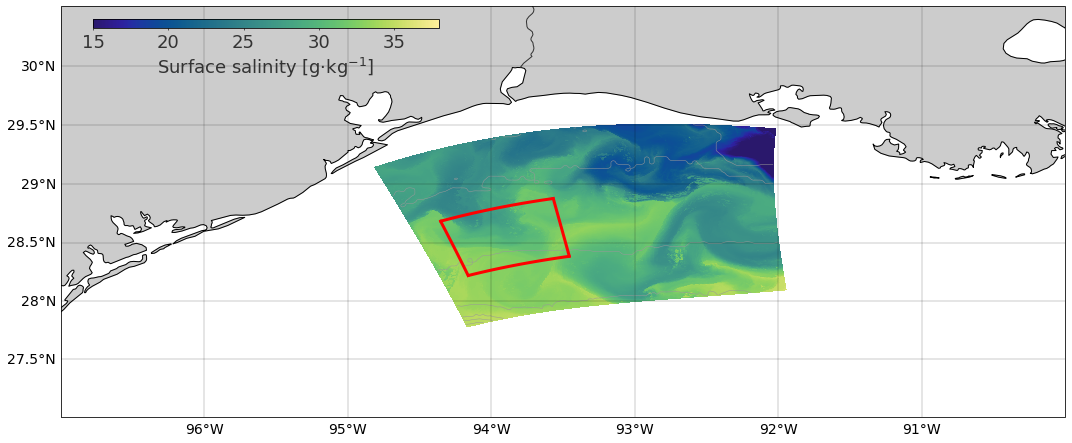

In [152]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=ccrs.Mercator(central_longitude=-85.0))

sal = ds.salt.sel(ocean_time='2010-06-03-01').isel(s_rho=-1).values
lon_rho = ds.salt['lon_rho'][:].data
lat_rho = ds.salt['lat_rho'][:].data
hlevs = [10, 20, 50, 100, 150, 200, 250, 300, 350, 400, 450]  # isobath contour depths

mappable = ax.pcolormesh(lon_rho, lat_rho, sal, 
                         cmap = cmo.haline, 
                         transform = cartopy.crs.PlateCarree(),
                         vmin = 15, vmax = 38)



gl = ax.gridlines(linewidth=0.4, color='black', alpha=0.5, linestyle='-', draw_labels=True)
ax.set_extent([-97, -90, 27, 30.5], ccrs.PlateCarree())
# ax.set_extent([-94.5, -93.5, 27, 30.5], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8')
ax.coastlines(resolution='10m')  
ax.add_feature(states_provinces, edgecolor='0.2')
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='0.2')
ax.set_aspect('auto')

cax = fig.add_axes([0.09, 0.91, 0.32, 0.02]) 
cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
cb.set_label(r'Surface salinity [g$\cdot$kg$^{-1}$]', fontsize=18, color='0.2')
cb.ax.tick_params(labelsize=18, length=2, color='0.2', labelcolor='0.2')

ax.contour(lon_rho, lat_rho, ds.h, hlevs, colors='0.6', transform=ccrs.PlateCarree(), linewidths=0.5)
ax.tick_params(axis='y', labelsize=18)

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False

ax.plot(QN.lon_v.values, QN.lat_v.values,'-r', transform=ccrs.PlateCarree(), lw = 3)
ax.plot(QS.lon_v.values, QS.lat_v.values,'-r', transform=ccrs.PlateCarree(), lw = 3)
ax.plot(QE.lon_u.values, QE.lat_u.values,'-r', transform=ccrs.PlateCarree(), lw = 3)
ax.plot(QW.lon_u.values, QW.lat_u.values,'-r', transform=ccrs.PlateCarree(), lw = 3)

In [154]:
xislice=slice(50,251) #note this is for the tendency terms - tef has xi-1 and yi-1 indices. 
etaslice=slice(150,351)

dV = ds.dV.isel(eta_rho=etaslice, xi_rho = xislice)

<img src='../outputs/tendencies/arakawa_grid.png' width='500'/>

Text(0.5, 1.0, 'Control Volume Grid Cell Locations')

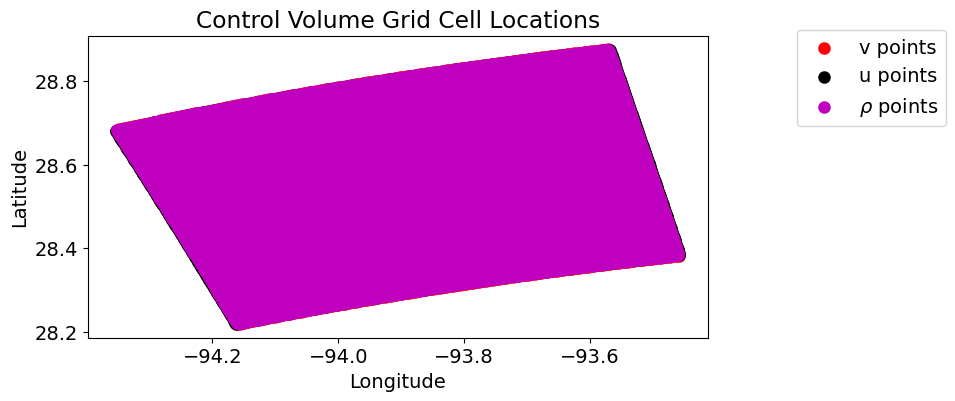

In [159]:
fig = plt.subplots(1, figsize = (8,4), dpi=100)

plt.scatter(QN.lon_v.values, QN.lat_v.values, c='r', lw = 3, label = 'v points')
plt.scatter(QS.lon_v.values, QS.lat_v.values, c='r', lw = 3)
plt.scatter(QE.lon_u.values, QE.lat_u.values, c='k', lw = 3, label = 'u points')
plt.scatter(QW.lon_u.values, QW.lat_u.values, c='k', lw = 3)

plt.scatter(dV.lon_rho.values, dV.lat_rho.values, c='m', lw = 3, label = r'$\rho$ points')
plt.scatter(dV.lon_rho.values, dV.lat_rho.values, c='m', lw = 3)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(bbox_to_anchor=(1.4, 1.05),)
plt.title('Control Volume Grid Cell Locations')

In [87]:
dVdt

<xarray.DataArray 'dVdt' (ocean_time: 1080)>
array([-2.67671252, -2.8082589 , -2.93620771, ..., -2.16982936,
       -2.06866391, -1.96621114])
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2010-06-03T02:00:00

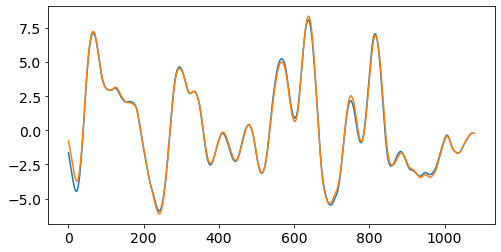

In [94]:
win = signal.hann(72)

dVdt = xr.apply_ufunc(signal.convolve, tendencies.dVdt, kwargs={'in2': win,'mode': 'same'})/sum(win)
tefvol = xr.apply_ufunc(signal.convolve, tef.voladv, kwargs={'in2': win,'mode': 'same'})/sum(win)
surflux = xr.apply_ufunc(signal.convolve, swflux.load(), kwargs={'in2': win,'mode': 'same'})/sum(win)

fig = plt.subplots(1, figsize = (8,4))
plt.plot(dVdt.values)
plt.plot(tefvol.values)
# surflux[100:].plot()

### Plot the volume budget: $\frac{\partial V}{\partial t} = Q_{in}+Q_{out}$

Text(0.5, 1.0, 'Volume Budget - No Surface Forcing')

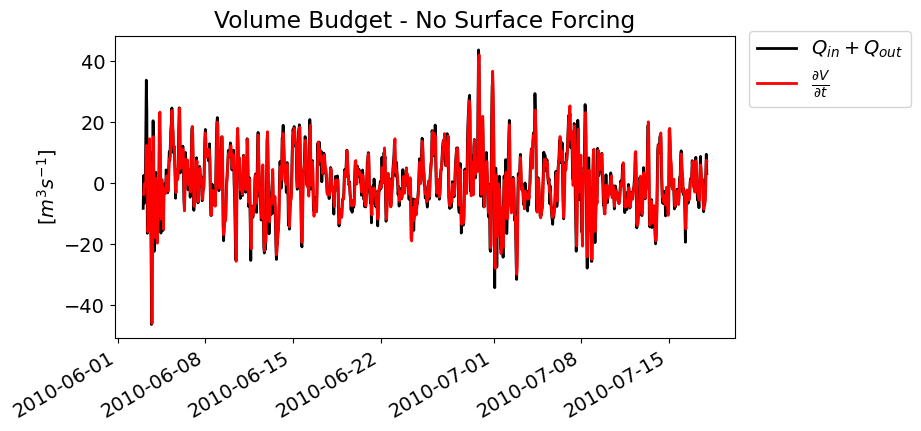

In [25]:
fig = plt.subplots(1, figsize = (8,4), dpi=100)

tef.voladv.plot(lw=2, color='k', label=r'$Q_{in}+Q_{out}$')
(tendencies.dVdt).plot(lw=2, color='r', label=r'$\frac{\partial V}{\partial t}$')

plt.xlabel('')
plt.ylabel(r'[$m^3 s^{-1}$]')
plt.legend(bbox_to_anchor=(1.3, 1.05))
plt.title('Volume Budget - No Surface Forcing')

Text(0.5, 1.0, 'Volume Budget - No Surface Forcing')

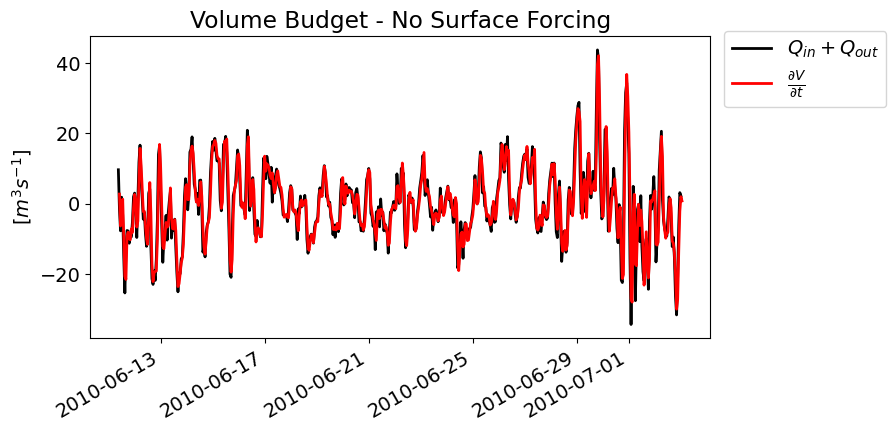

In [26]:
fig = plt.subplots(1, figsize = (8,4),dpi=100)

tef.voladv[200:720].plot(lw=2, color='k', label=r'$Q_{in}+Q_{out}$')
tendencies.dVdt[200:720].plot(lw=2, color='r', label=r'$\frac{\partial V}{\partial t}$')

plt.xlabel('')
plt.ylabel(r'[$m^3 s^{-1}$]')
plt.legend(bbox_to_anchor=(1.3, 1.05))
plt.title('Volume Budget - No Surface Forcing')

### Look at the total transport over the simulation length

In [27]:
print(tef.voladv[200:720].sum().values, 'tef sum [m^3/s]')
print(tendencies.dVdt[200:720].sum().values, 'tendency sum [m^3/s]')
print(tef.voladv[200:720].sum().values-tendencies.dVdt[200:720].sum().values, 'sum difference[m^3/s]')

pdif = (((tef.voladv[200:720].sum().values)-(tendencies.dVdt[200:720].sum().values)) \
        /(tendencies.dVdt[200:720].sum().values))*100
print(pdif, 'Percent difference')

-68.02012416130185 tef sum [m^3/s]
-65.7316317732467 tendency sum [m^3/s]
-2.288492388055147 sum difference[m^3/s]
3.481569415391543 Percent difference


In [52]:
tefvol[100:].sum()

<xarray.DataArray 'voladv' ()>
array(0.90120455)

In [51]:
dVdt[100:].sum()

<xarray.DataArray 'dVdt' ()>
array(2.73506424)

In [48]:
print(tefvol.sum().values, 'tef sum [m^3/s]')
print(dVdt.sum().values, 'tendency sum [m^3/s]')
print(tefvol.sum().values-dVdt.sum().values, 'sum difference[m^3/s]')

pdif = (((tefvol.sum().values)-(dVdt.sum().values)) \
        /(dVdt.sum().values))*100
print(pdif, 'Percent difference')

204.2977478356194 tef sum [m^3/s]
172.3892476015241 tendency sum [m^3/s]
31.9085002340953 sum difference[m^3/s]
18.509565229875275 Percent difference


### Plot the salt budget: $\frac{\partial (sV)}{\partial t} = Q_{in}s_{in}+Q_{out}s_{out}$

Text(0.5, 1.0, 'Salt Budget - No Surface Forcing')

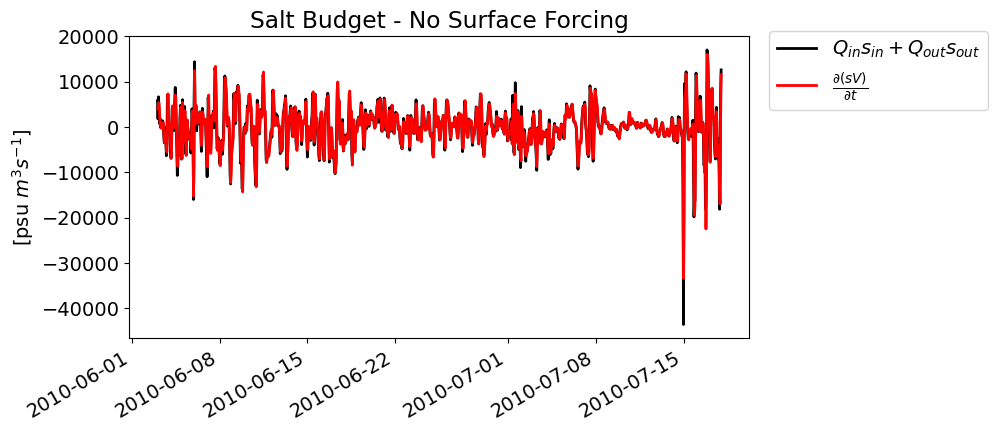

In [28]:
fig = plt.subplots(1, figsize = (8,4), dpi = 100)

tef.saltadv.plot(lw=2, color='k', label=r'$Q_{in}s_{in}+Q_{out}s_{out}$')
tendencies.dsVdt.plot(lw=2, color='r', label=r'$\frac{\partial (sV)}{\partial t}$')

plt.xlabel('')
plt.ylabel(r'[psu $m^3 s^{-1}$]')
plt.legend(bbox_to_anchor=(1.4, 1.05))
plt.title('Salt Budget - No Surface Forcing')

In [29]:
print(tef.saltadv.sum().values, 'tef sum [m^3]')
print(tendencies.dsVdt.sum().values, 'tendency sum [m^3]')

pdif = (((tef.saltadv.sum().values)-(tendencies.dsVdt.sum().values)) \
        /(tendencies.dsVdt.sum().values))*100
print(pdif, 'Percent difference')

-103880.82396523535 tef sum [m^3]
-107084.95388385034 tendency sum [m^3]
-2.9921382999243225 Percent difference


### Plot the salt squared budget: $\frac{\partial (s^2V)}{\partial t} = Q_{in}s^2_{in}+Q_{out}s^2_{out} - \chi$, 

$\chi = 2 \iiint_{V}[K_v(\frac{\partial s}{\partial z})^2] dV$

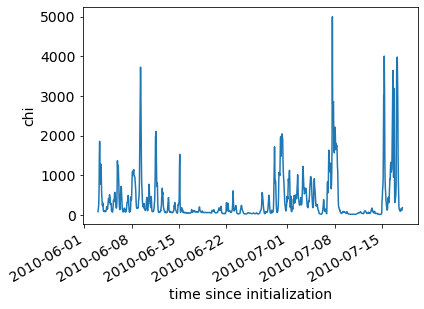

In [33]:
chi = xr.open_dataset('../outputs/mixing/dissipation_nested_hourly.nc').chi
chi.plot()

### The vertical mixing appears to blow up at the beginning - this doesnt seem real

Text(0.5, 1.0, 'Salt Squared Budget - No Surface Forcing')

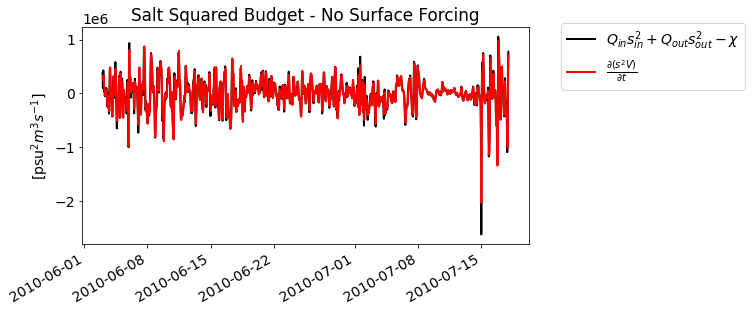

In [34]:
fig = plt.subplots(1, figsize = (8,4))

(tef.ssaltadv-chi).plot(lw=2, color='k', label=r'$Q_{in}s^2_{in}+Q_{out}s^2_{out}-\chi$')
# (tef.ssaltadv).plot(lw=2, color='r', label=r'$Q_{in}s^2_{in}+Q_{out}s^2_{out}$')
tendencies.dssVdt.plot(lw=2, color='r', label=r'$\frac{\partial (s^2V)}{\partial t}$')

plt.xlabel('')
plt.ylabel(r'[psu$^2 m^3 s^{-1}$]')
plt.legend(bbox_to_anchor=(1.5, 1.05))
plt.title('Salt Squared Budget - No Surface Forcing')

In [35]:
print((tef.ssaltadv-chi).sum().values*2588400, 'tef sum [m^3]')
print(tendencies.dssVdt.sum().values*2588400, 'tendency sum [m^3]')

pdif = ((((tef.ssaltadv-chi).sum().values*2588400)-(tendencies.dssVdt.sum().values*2588400)) \
        /(tendencies.dssVdt.sum().values*2588400))*100
print(pdif, 'Percent difference')

-17000636218237.896 tef sum [m^3]
-17715085210821.363 tendency sum [m^3]
-4.032997776082056 Percent difference


### Plot the salt variance budget: $\frac{\partial (s'^2V)}{\partial t} = Q_{in}s'^2_{in}+Q_{out}s'^2_{out} - \chi$

Text(0.5, 1.0, 'Salt Variance Budget - No Surface Forcing')

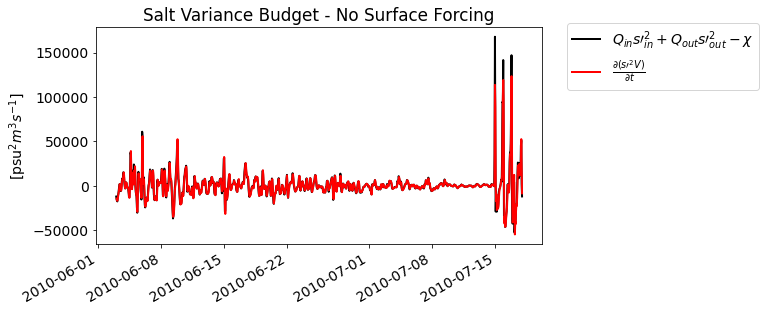

In [36]:
fig = plt.subplots(1, figsize = (8,4))

(tef.svaradv-chi).plot(lw=2, color='k', label=r'$Q_{in}s \prime^2_{in}+Q_{out}s \prime^2_{out}-\chi$')
# (tef.ssaltadv).plot(lw=2, color='r', label=r'$Q_{in}s^2_{in}+Q_{out}s^2_{out}$')
tendencies.dsvardt.plot(lw=2, color='r', label=r'$\frac{\partial (s \prime^2V)}{\partial t}$')

plt.xlabel('')
plt.ylabel(r'[psu$^2 m^3 s^{-1}$]')
plt.legend(bbox_to_anchor=(1.5, 1.05))
plt.title('Salt Variance Budget - No Surface Forcing')

In [37]:
print((tef.svaradv-chi).sum().values, 'tef sum [m^3]')
print(tendencies.dsvardt.sum().values, 'tendency sum [m^3]')

pdif = ((((tef.svaradv-chi).sum().values)-(tendencies.dsvardt.sum().values)) \
        /(tendencies.dsvardt.sum().values))*100
print(pdif, 'Percent difference')
# print()

285191.69872931135 tef sum [m^3]
179114.1666138418 tendency sum [m^3]
59.22341829285096 Percent difference


## Let's look at the surface forcing to see how it impacts the budgets

In [65]:
dss = xr.open_dataset('/scratch/user/dylan.schlichting/TXLA_Outputs/txla2_frc_ERAI_nest.nc')

dss = dss.sel(time = slice('2010-06-02 23:00:00', '2010-07-18 00:00:00')) \
         .isel(xi_rho = xislice, eta_rho = etaslice)

In [66]:
dss

<xarray.Dataset>
Dimensions:      (eta_rho: 10, eta_u: 602, eta_v: 601, time: 361, xi_rho: 10, xi_u: 676, xi_v: 677)
Coordinates:
  * time         (time) datetime64[ns] 2010-06-03 ... 2010-07-18
Dimensions without coordinates: eta_rho, eta_u, eta_v, xi_rho, xi_u, xi_v
Data variables:
    Pair         (time, eta_rho, xi_rho) float64 ...
    Qair         (time, eta_rho, xi_rho) float64 ...
    Tair         (time, eta_rho, xi_rho) float64 ...
    Uwind        (time, eta_rho, xi_rho) float64 ...
    Vwind        (time, eta_rho, xi_rho) float64 ...
    cloud        (time, eta_rho, xi_rho) float64 ...
    evaporation  (time, eta_rho, xi_rho) float64 ...
    lwrad        (time, eta_rho, xi_rho) float64 ...
    rain         (time, eta_rho, xi_rho) float64 ...
    shflux       (time, eta_rho, xi_rho) float64 ...
    sustr        (time, eta_u, xi_u) float64 ...
    svstr        (time, eta_v, xi_v) float64 ...
    swflux       (time, eta_rho, xi_rho) float64 ...
    swrad        (time, eta_rho, xi_rho) float64 ...
    wspd         (time, eta_rho, xi_rho) float64 ...
Attributes:
    type:      ROMS Bulk forcing file
    title:     ROMS Bulk forcing file
    grd_file:  /Users/dj/ROMS/ROMStool/mypython/grd/txla_grd_v4_new.nc
    history:   Sat Apr 11 12:38:18 2020: ncks -d time,1200,1760 txla_bulk_ERA...
    author:    dj, Daijiros-MacBook-Pro.local
    dataset:   ECMWF ERA-Interim
    NCO:       "4.6.0"

#### The surface forcing is on a daily frequency - so let's resample it to hourly

In [67]:
swflux = dss.swflux.resample(time = '1h').interpolate('linear') #one extra time step at beginning, cut it.

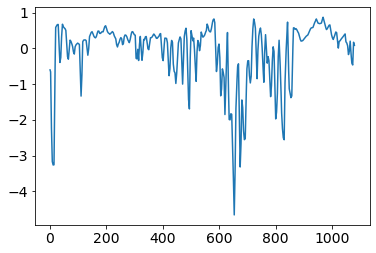

In [68]:
swflux = (swflux[1:]/100)/86400 #convert from cm/d to m/s
dA = (ds.dx*ds.dy).isel(eta_rho = etaslice, xi_rho = xislice)
swflux = (swflux*dA).sum(dim = ['eta_rho','xi_rho'])
# swflux.sum().values
plt.plot(swflux)

In [ ]:
swflux.sum().values

### Redo the volume budget to include the surface forcing. ROMS computes the net E/P as the variable swflux, sign convention positive into the ocean negative evaporation

Sign convention of swflux:   positive_value : downward flux, precipitation, negative_value : upward flux, evaporation. In other words, into the ocean is positive and out of the ocean is negative. So we add the net freshwater flux to the advection term.

Text(0.5, 1.0, 'Volume Budget with Surface Forcing')

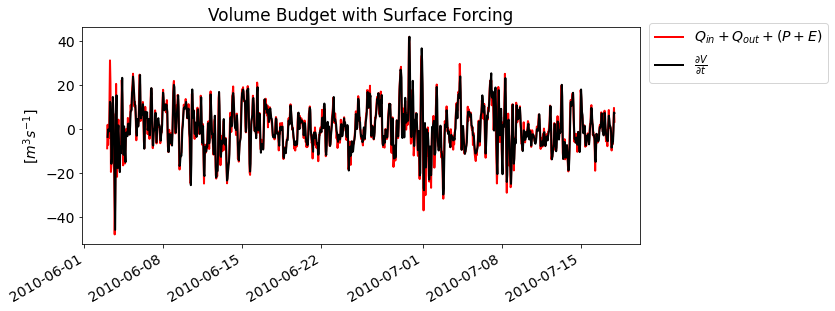

In [71]:
fig = plt.subplots(1, figsize = (10,4))

(tef.voladv+swflux.values).plot(lw=2, color='r', label=r'$Q_{in}+Q_{out}+(P+E)$')
(tendencies.dVdt).plot(lw=2, color='k', label=r'$\frac{\partial V}{\partial t}$')

plt.xlabel('')
plt.ylabel(r'[$m^3 s^{-1}$]')
plt.legend(bbox_to_anchor=(1.35, 1.05))
plt.title('Volume Budget with Surface Forcing')

In [73]:
advsum = (tef.voladv.values-swflux.values).sum()
tendsum = (tendencies.dVdt.values).sum()
vpdiff = ((advsum-tendsum)/tendsum)*100

print(advsum, 'tef+surface fluxes sum [m^3]')
print(tendsum, 'tendency sum [m^3]')
print(vpdiff, 'Percent difference')

316.49341371494916 tef+surface fluxes sum [m^3]
161.07930760502805 tendency sum [m^3]
96.48297377277147 Percent difference


In [ ]:
err = tendencies.dVdt.values-tef.voladv.values+swflux.values

plt.scatter(err,swflux.values)

### Adding the surface fluxes appears to significantly improve the volume budget. There is a 9% difference between the two. Let's move on to the salt budget

ssflux has the following sign convention. negative_value : upward flux, freshening (net precipitation), positive_value : downward flux, salting (net evaporation). So we add this to the tef terms

In [ ]:
ssflux = (ds.ssflux*dA).sum(dim = ['eta_rho', 'xi_rho'])

In [ ]:
ssflux.plot()

In [ ]:
fig = plt.subplots(1, figsize = (8,4))

(tef.saltadv+ssflux).plot(lw=2, color='k', label=r'$Q_{in}s_{in}+Q_{out}s_{out}+s(P+E)$')
(tendencies.dsVdt).plot(lw=2, color='r', label=r'$\frac{\partial (sV)}{\partial t}$')

plt.xlabel('')
plt.ylabel(r'[$m^3 s^{-1}$]')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Salt Budget with Surface Forcing')

In [ ]:
advsum = (tef.saltadv.values+ssflux.values).sum()*2588400
tendsum = (tendencies.dsVdt.values).sum()*2588400
vpdiff = ((advsum-tendsum)/tendsum)*100

print(advsum, 'tef+surface fluxes sum [m^3]')
print(tendsum, 'tendency sum [m^3]')
print(vpdiff, 'Percent difference')

### The salt budget has slightly more than twice the error of the volume budget, around 15 %. What about salt squared? 

In [ ]:
ssquare_flux = 

In [ ]:
fig = plt.subplots(1, figsize = (8,4))

(tef.ssaltadv+chi-(ssflux.values**2)/swflux.values).plot(lw=2, color='k', label=r'$Q_{in}s^2_{in}+Q_{out}s^2_{out}-\chi + s^2(P+E)$')
(tendencies.dssVdt).plot(lw=2, color='r', label=r'$\frac{\partial (s^2V)}{\partial t}$')
# (tendencies.dssVdt+(ssflux.values**2)).plot(lw=2, color='r', label=r'$\frac{\partial (s^2V)}{\partial t}+s^2(E-P)$')

plt.xlabel('')
plt.ylabel(r'[$(g kg^{-1})m^3 s^{-1}$]')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Salt Squared Budget with Surface Forcing')

In [ ]:
advsum = (tef.ssaltadv.values+((ssflux.values**2)/swflux.values)-chi.values).sum()*2588400
tendsum = (tendencies.dssVdt.values).sum()*2588400
vpdiff = ((advsum-tendsum)/tendsum)*100

print(advsum, 'tef+surface fluxes sum [m^3]')
print(tendsum, 'tendency sum [m^3]')
print(vpdiff, 'Percent difference')